# Importation des bibliothèques

In [1]:
!pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable


In [2]:
# Importation des bibliothèques nécessaires à tout le projet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.utils import resample
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay,
                             classification_report, roc_curve, auc)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU, ELU
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline
import os
import joblib
from scikeras.wrappers import KerasClassifier
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, ConfusionMatrixDisplay

# Configuration des graphiques
plt.style.use('ggplot')
sns.set_theme()

2024-12-14 16:34:40.387789: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-14 16:34:40.431095: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-14 16:34:40.441437: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-14 16:34:40.467960: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-14 16:34:43.777276: W tensorflow/compiler/tf2

# Classification d'extractions d'ocr

Ce projet vise à classifier différents elements scannés par google ocr ['inutile', 'paragraphe', 'titre']

Les étapes :

- Présentation et exploration des données
- Préparation et nettoyage des données
- Analyse exploratoire avec visualisations
- Sélection et réduction des variables
- Entraînement et évaluation de plusieurs modèles
- Optimisation des hyperparamètres
- Sélection du modèle final (XGBoost) et enregistrement des poids


# Chargement et Présentation des Données


In [28]:
# Chargement du dataset
dataset_path = "../data/csv_manual/training_data.csv"
data = pd.read_csv(dataset_path)
# Aperçu des premières lignes du dataset
print("Extrait du dataset : \n")
display(data.tail())


Extrait du dataset : 



,width,height,area,chars,char_size,pos_x,pos_y,aspect,layout,x0,x1,y0,y1,label
1775,0.173109,0.010702,0.001853,30,0.000062,0.237815,0.532105,16.176016,h,0.151261,0.324370,0.526754,0.529132,titre
1776,0.490756,0.009513,0.004668,88,0.000053,0.396639,0.554102,51.590674,h,0.151261,0.642017,0.549346,0.549346,titre
1777,0.717647,0.024970,0.017920,162,0.000111,0.510084,0.582045,28.740038,h,0.151261,0.868908,0.569560,0.570749,paragraphe
1778,0.016807,0.008323,0.000140,3,0.000047,0.497479,0.938763,2.019210,h,0.489076,0.505882,0.934602,0.934602,inutile
1779,0.132773,0.007134,0.000947,18,0.000053,0.498319,0.973841,18.610271,h,0.431933,0.564706,0.970274,0.970274,inutile


In [29]:
# Dimensions du dataset
print(f"Nombre d'observations (lignes) : {data.shape[0]}")
print(f"Nombre de variables (colonnes) : {data.shape[1]}")

Nombre d'observations (lignes) : 1780
Nombre de variables (colonnes) : 14


In [30]:
# Informations sur les types de données
print("Informations sur les types de données : \n")
data.info()

Informations sur les types de données : 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1780 entries, 0 to 1779
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   width      1780 non-null   float64
 1   height     1780 non-null   float64
 2   area       1780 non-null   float64
 3   chars      1780 non-null   int64  
 4   char_size  1780 non-null   float64
 5   pos_x      1780 non-null   float64
 6   pos_y      1780 non-null   float64
 7   aspect     1780 non-null   float64
 8   layout     1780 non-null   object 
 9   x0         1780 non-null   float64
 10  x1         1780 non-null   float64
 11  y0         1780 non-null   float64
 12  y1         1780 non-null   float64
 13  label      1780 non-null   object 
dtypes: float64(11), int64(1), object(2)
memory usage: 194.8+ KB


In [31]:
# Identification des colonnes numériques et textuelles
numerical_features = data.select_dtypes(include=[np.number]).columns.tolist()
textual_features = data.select_dtypes(include=['object']).columns.tolist()
print("Variables numériques :", numerical_features)
print("Variables textuelles :", textual_features)

Variables numériques : ['width', 'height', 'area', 'chars', 'char_size', 'pos_x', 'pos_y', 'aspect', 'x0', 'x1', 'y0', 'y1']
Variables textuelles : ['layout', 'label']


# Analyse Préparatoire des Données

## Vérification des Valeurs Manquantes

In [32]:
# Valeurs manquantes
print("\nValeurs manquantes dans le dataset :\n")
print(data.isnull().sum())


Valeurs manquantes dans le dataset :

width        0
height       0
area         0
chars        0
char_size    0
pos_x        0
pos_y        0
aspect       0
layout       0
x0           0
x1           0
y0           0
y1           0
label        0
dtype: int64


## Suppression des Valeurs Manquantes

In [33]:
# Suppression avec KNNImputer pour les variables numériques
suppr = KNNImputer(n_neighbors=5)
data_numeric = data[numerical_features]
data_imputed = suppr.fit_transform(data_numeric)
data_cleaned = data.copy()
data_cleaned[numerical_features] = data_imputed

In [34]:
# Vérification après imputation
print("Valeurs manquantes après suppression des lignes avec valeurs manquantes :")
print(data_cleaned.isnull().sum())

Valeurs manquantes après suppression des lignes avec valeurs manquantes :
width        0
height       0
area         0
chars        0
char_size    0
pos_x        0
pos_y        0
aspect       0
layout       0
x0           0
x1           0
y0           0
y1           0
label        0
dtype: int64


## Statistiques descriptives

In [35]:
# Statistiques descriptives des variables numériques
print("Statistiques descriptives :\n")
display(data_cleaned[numerical_features].describe())

Statistiques descriptives :



,width,height,area,chars,char_size,pos_x,pos_y,aspect,x0,x1,y0,y1
count,1780.000000,1780.000000,1780.000000,1780.000000,1780.000000,1780.000000,1780.000000,1780.000000,1780.000000,1780.000000,1780.000000,1780.000000
mean,0.283955,0.019439,0.010117,92.567416,0.000110,0.501901,0.471400,14.421742,0.359943,0.643860,0.461893,0.461862
std,0.294259,0.023968,0.019341,175.742963,0.001234,0.204218,0.257628,13.056546,0.272341,0.229218,0.258532,0.258584
min,0.003361,0.001189,0.000008,1.000000,0.000008,0.119328,0.048751,0.249431,0.058824,0.121008,0.043995,0.042806
25%,0.025210,0.007134,0.000180,5.000000,0.000041,0.347689,0.266350,3.533609,0.117647,0.490756,0.253270,0.253270
50%,0.132773,0.009512,0.001488,21.000000,0.000063,0.498319,0.429845,10.772527,0.191597,0.700840,0.423306,0.423306
75%,0.582773,0.024970,0.008418,80.250000,0.000105,0.619958,0.676724,19.788245,0.598740,0.878992,0.669441,0.669441
max,0.764706,0.368609,0.280638,2692.000000,0.052063,0.915966,0.973841,80.036556,0.907563,0.969748,0.970274,0.970274


# Analyse Exploratoire avec Visualisations

## Distribution des Variables Numériques

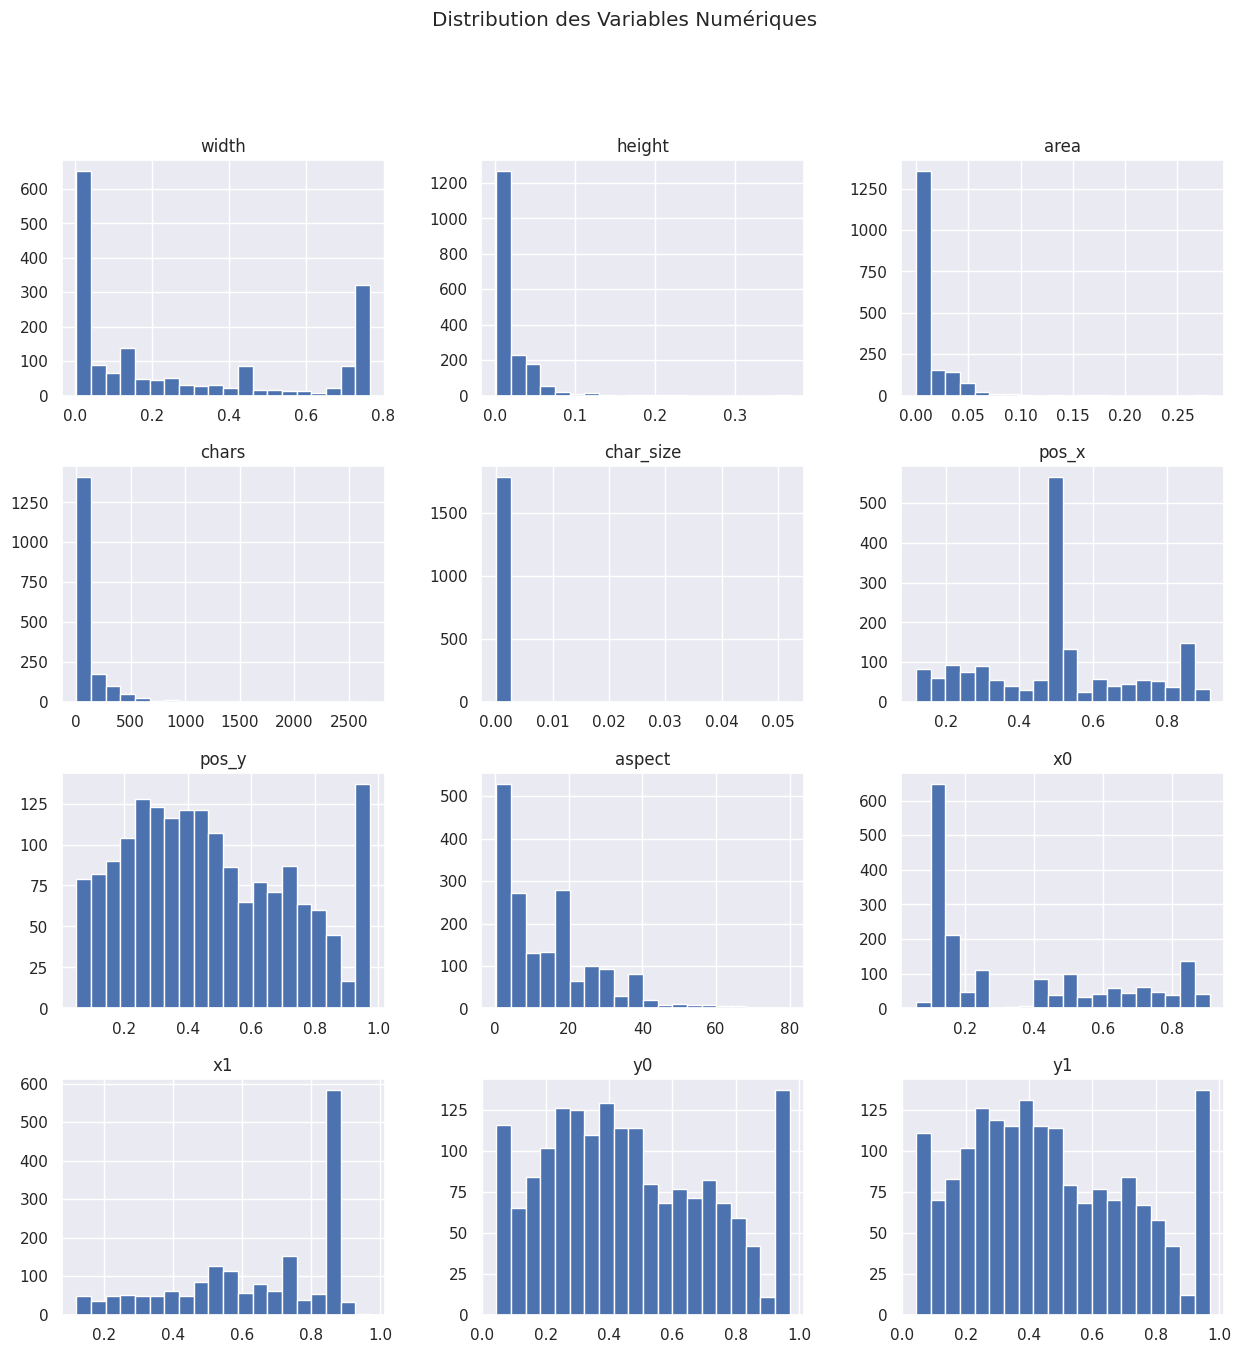

In [36]:
# Histogrammes pour visualiser les distributions
data_cleaned[numerical_features].hist(bins=20, figsize=(15, 15))
plt.suptitle("Distribution des Variables Numériques")
plt.show()

## Distribution de la Variable Cible

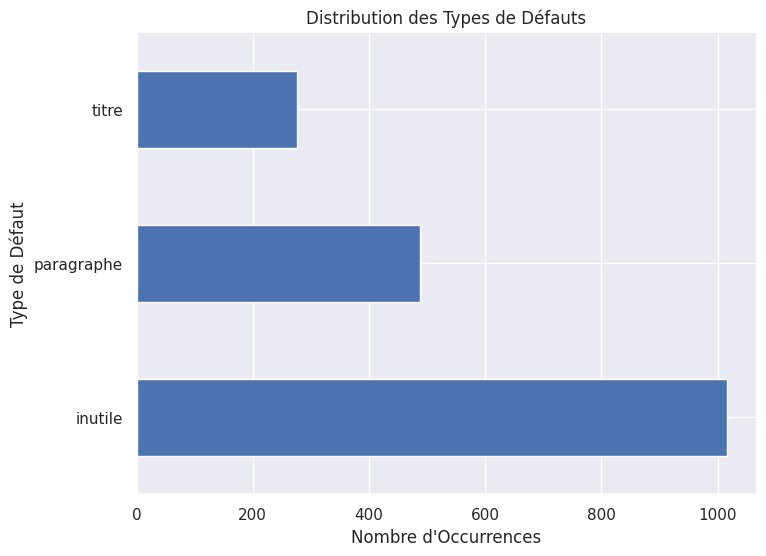

In [37]:
# Distribution de la variable cible 'target'
plt.figure(figsize=(8, 6))
data_cleaned['label'].value_counts().plot(kind='barh')
plt.title("Distribution des Types de Défauts")
plt.xlabel("Nombre d'Occurrences")
plt.ylabel("Type de Défaut")
plt.show()

## Matrice de corrélation

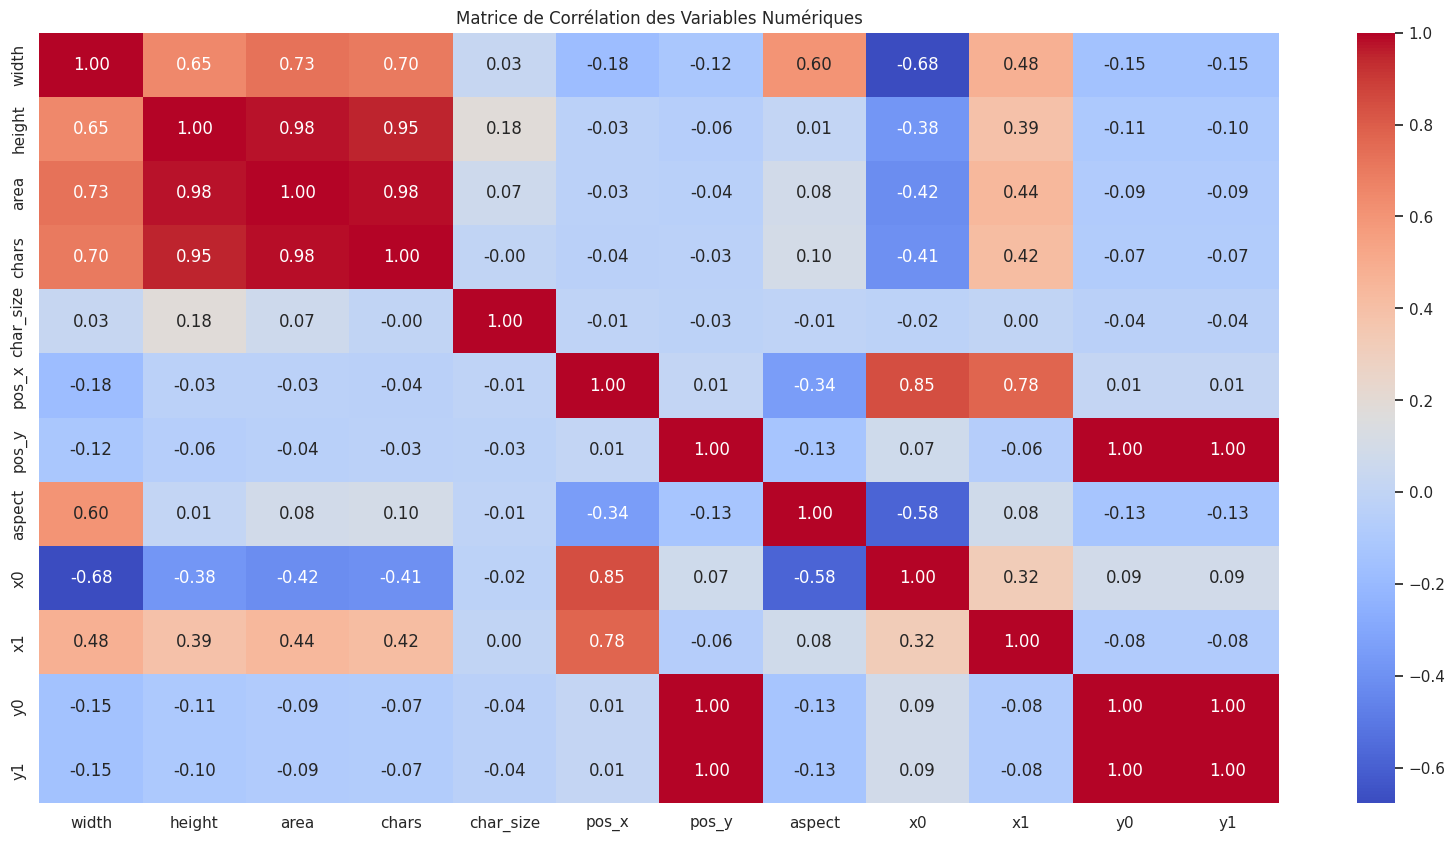

In [38]:
plt.figure(figsize=(20, 10))
sns.heatmap(data_cleaned[numerical_features].corr(), annot=True, fmt=".2f", cmap="coolwarm", square=False)
plt.title("Matrice de Corrélation des Variables Numériques")
plt.show()

## Boxplots par Feature

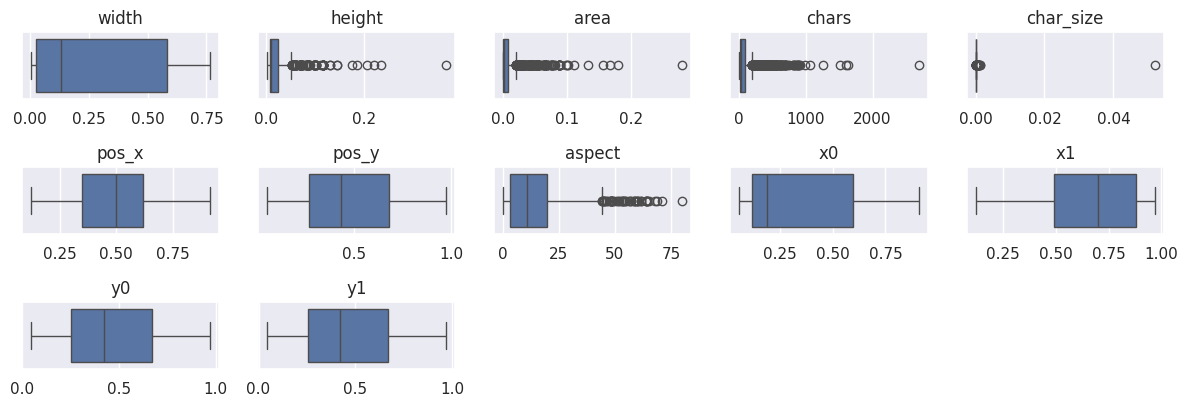

In [39]:
# Dimensions de la figure globale
fig, axes = plt.subplots(nrows=6, ncols=5, figsize=(12, 8))
axes = axes.flatten()
# Afficher un boxplot pour chaque feature numérique dans la même figure
for i, col in enumerate(numerical_features):
    sns.boxplot(x=data_cleaned[col], ax=axes[i])
    axes[i].set_title(f"{col}")
    axes[i].set_xlabel("")  # Supprime l'étiquette de l'axe x en bas
# Supprimer les sous-figures inutilisées si nécessaire
for i in range(len(numerical_features), len(axes)):
    fig.delaxes(axes[i])
# Ajuster la disposition
plt.tight_layout()
plt.show()



# Préparation des Données

## Encodage de la variable cible

In [40]:
# Pour 'layout'
label_encoder_layout = LabelEncoder()
data_cleaned['layout'] = label_encoder_layout.fit_transform(data_cleaned['layout'])

# Pour 'label'
label_encoder_label = LabelEncoder()
data_cleaned['target_encoded'] = label_encoder_label.fit_transform(data_cleaned['label'])

print("\nMapping pour 'label':")
for label, encoded_value in zip(label_encoder_label.classes_, range(len(label_encoder_label.classes_))):
    print(f"{label} -> {encoded_value}")


Mapping pour 'label':
inutile -> 0
paragraphe -> 1
titre -> 2


In [41]:
data_cleaned.tail()

,width,height,area,chars,char_size,pos_x,pos_y,aspect,layout,x0,x1,y0,y1,label,target_encoded
1775,0.173109,0.010702,0.001853,30.0,0.000062,0.237815,0.532105,16.176016,0,0.151261,0.324370,0.526754,0.529132,titre,2
1776,0.490756,0.009513,0.004668,88.0,0.000053,0.396639,0.554102,51.590674,0,0.151261,0.642017,0.549346,0.549346,titre,2
1777,0.717647,0.024970,0.017920,162.0,0.000111,0.510084,0.582045,28.740038,0,0.151261,0.868908,0.569560,0.570749,paragraphe,1
1778,0.016807,0.008323,0.000140,3.0,0.000047,0.497479,0.938763,2.019210,0,0.489076,0.505882,0.934602,0.934602,inutile,0
1779,0.132773,0.007134,0.000947,18.0,0.000053,0.498319,0.973841,18.610271,0,0.431933,0.564706,0.970274,0.970274,inutile,0


# Sélection et réduction des varibales

## Suppression des variables fortement corrélées

In [42]:
# Suppression des variables redondantes
correlated_features = ['pos_y', 'y0', 'area']
# , 'TypeOfSteel_A400'
data_reduced = data_cleaned.drop(columns=correlated_features)

## Réaffichage de la matrice de corrélation

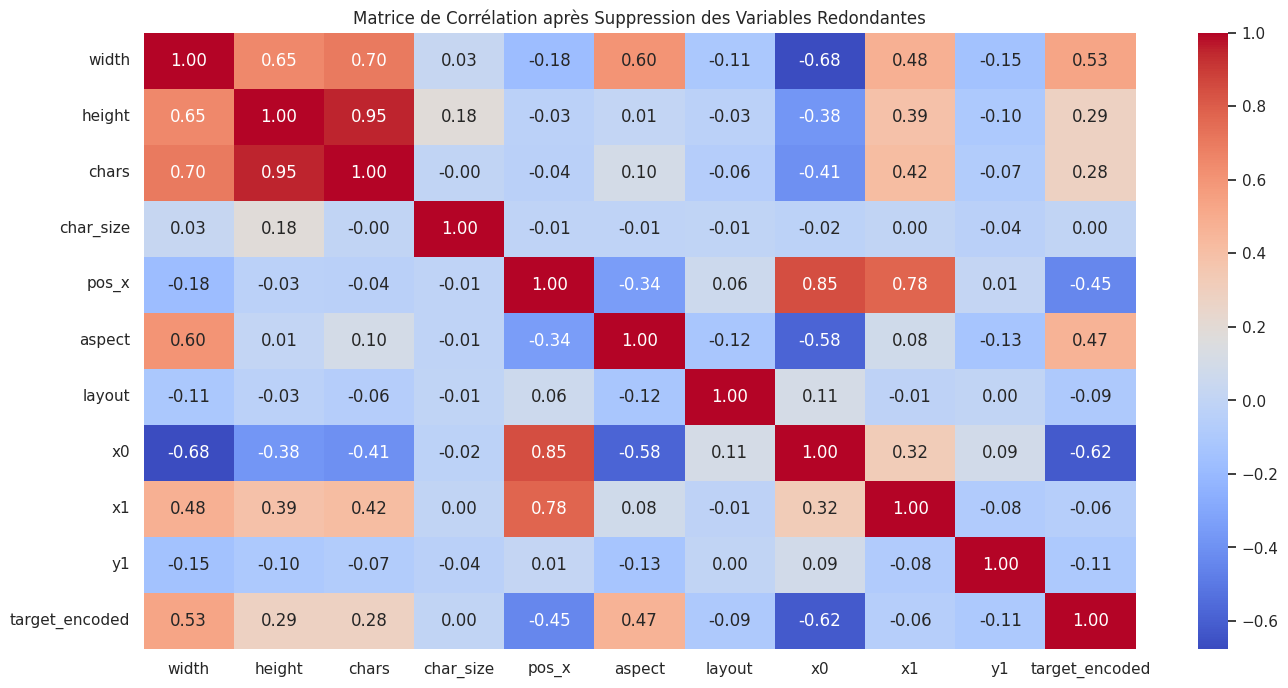

In [43]:
# Mise à jour de la liste des variables numériques après suppression des variables corrélées
numerical_features_reduced = data_reduced.select_dtypes(include=[np.number]).columns.tolist()
# Matrice de corrélation après suppression des variables redondantes
plt.figure(figsize=(16, 8))
sns.heatmap(data_reduced[numerical_features_reduced].corr(), annot=True, fmt=".2f", cmap="coolwarm", square=False)
plt.title("Matrice de Corrélation après Suppression des Variables Redondantes")
plt.show()

## Réaffichage des valeurs numériques et textuelles

In [44]:
# Liste des noms des colonnes des features numériques réduites
numerical_features_reduced = data_reduced.select_dtypes(include=[np.number]).columns.tolist()

# Affichage des noms des features dans une liste
print(len(numerical_features_reduced))

11


# Traitement des données

## Traitement des valeurs abérantes

In [45]:
# Suppression des valeurs aberrantes
X = data_reduced.drop(columns=['label', 'target_encoded'])
y = data_reduced['target_encoded']
X_filtered = X.copy()
for col in X_filtered.columns:
    Q1 = X_filtered[col].quantile(0.25)
    Q3 = X_filtered[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    X_filtered = X_filtered[(X_filtered[col] >= lower_bound) & (X_filtered[col] <= upper_bound)]
# Synchronisation de y après suppression des valeurs aberrantes
indices_filtered = X_filtered.index
y_filtered = y.loc[indices_filtered].reset_index(drop=True)
X_filtered.reset_index(drop=True, inplace=True)

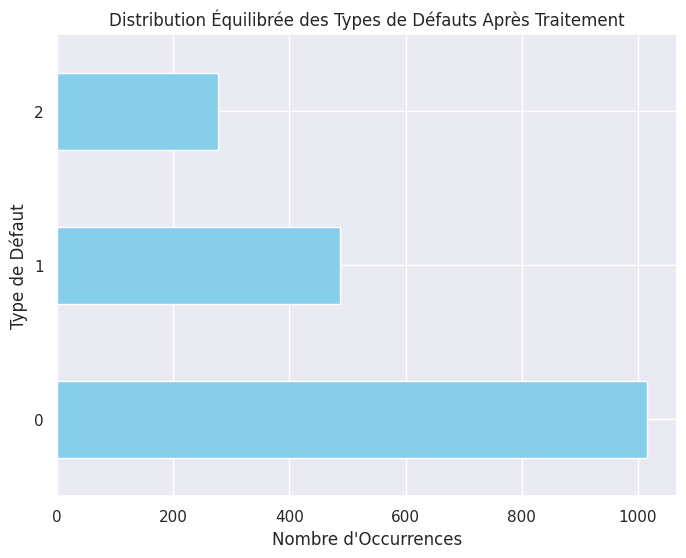

In [46]:
# Nouvelle distribution de la variable cible après équilibrage et réduction de dimension
plt.figure(figsize=(8, 6))
y.value_counts().plot(kind='barh', color='skyblue')
plt.title("Distribution Équilibrée des Types de Défauts Après Traitement")
plt.xlabel("Nombre d'Occurrences")
plt.ylabel("Type de Défaut")
plt.show()

## Resampling (undersampling et oversampling pour atteindre 600 pour chaque target)

In [47]:
# Concaténation de X_filtered et y_filtered pour préparer l'équilibrage
data_filtered = X_filtered.copy()
data_filtered['label'] = y_filtered
# Rééquilibrage des classes après suppression des valeurs aberrantes
data_balanced = []
# Itération sur chaque classe pour ajuster le nombre d'échantillons
for class_label in data_filtered['label'].unique():
    data_class = data_filtered[data_filtered['label'] == class_label]
    if len(data_class) < 400:
        # Pour les autres classes avec moins de 400 échantillons, utiliser un sur-échantillonnage
        data_class_balanced = resample(data_class, replace=True, n_samples=600, random_state=42)
    else:
        # Sinon, réaliser un sous-échantillonnage sans remplacement
        data_class_balanced = resample(data_class, replace=False, n_samples=600, random_state=42)
    data_balanced.append(data_class_balanced)
# Concaténation et mélange final des classes équilibrées
data_balanced = pd.concat(data_balanced).sample(frac=1, random_state=42).reset_index(drop=True)
# Séparation des features et de la label pour la suite du traitement
X_final = data_balanced.drop('label', axis=1)
y_final = data_balanced['label']

## Réduction de la dimensionalité avec PCA

In [48]:
# Réduction de dimensionnalité avec PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_final)
pca = PCA(n_components=0.95)  # Conserve 95% de la variance
X_pca = pca.fit_transform(X_scaled)
X_final_pca = pd.DataFrame(X_pca)

## Nouvelle distribution de la data

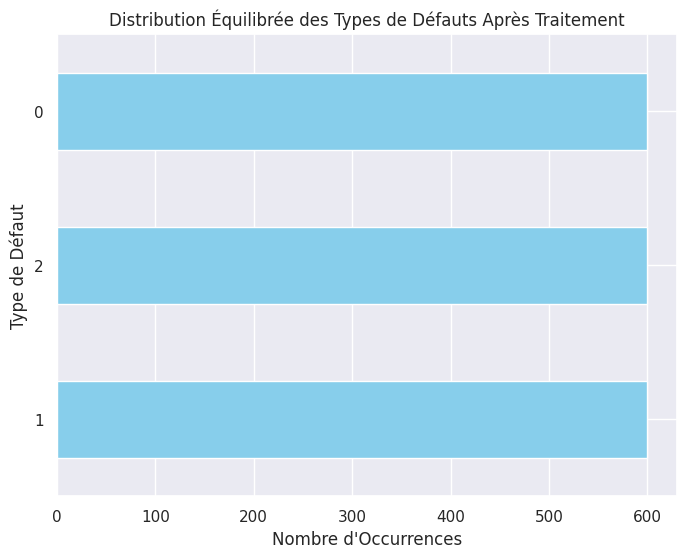

In [49]:
# Nouvelle distribution de la variable cible après équilibrage et réduction de dimension
plt.figure(figsize=(8, 6))
y_final.value_counts().plot(kind='barh', color='skyblue')
plt.title("Distribution Équilibrée des Types de Défauts Après Traitement")
plt.xlabel("Nombre d'Occurrences")
plt.ylabel("Type de Défaut")
plt.show()

## Séparation du dataset

In [50]:
# Séparation en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_final_pca, y_final,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y_final)

# Entraînement et Évaluation des Modèles machine learning

## Modèle 1 : K-Nearest Neighbors (KNN)

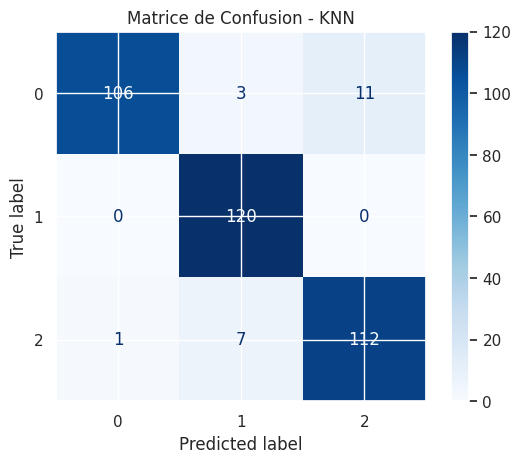



KNN - Rapport de Classification :

              precision    recall  f1-score   support

           0       0.99      0.88      0.93       120
           1       0.92      1.00      0.96       120
           2       0.91      0.93      0.92       120

    accuracy                           0.94       360
   macro avg       0.94      0.94      0.94       360
weighted avg       0.94      0.94      0.94       360





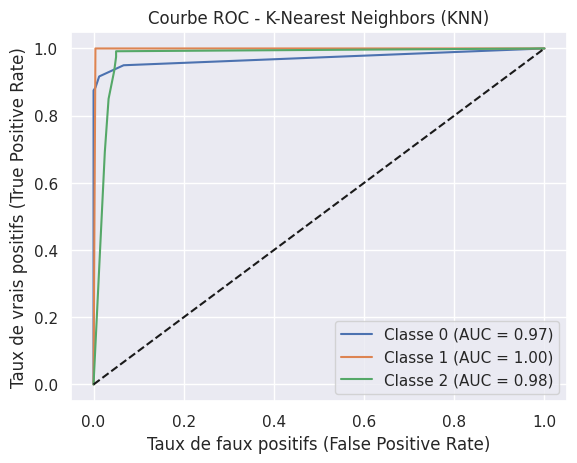

In [51]:
# Entraînement du modèle KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
# Prédictions et évaluation
y_pred_knn = knn.predict(X_test)
cm_knn = confusion_matrix(y_test, y_pred_knn)
ConfusionMatrixDisplay(cm_knn).plot(cmap="Blues")
plt.title("Matrice de Confusion - KNN")
plt.show()

print("\n" + "="*30 + "\n")

print("KNN - Rapport de Classification :\n")
print(classification_report(y_test, y_pred_knn))

print("\n" + "="*30 + "\n")

# Courbe ROC et AUC
y_test_bin = label_binarize(y_test, classes=np.unique(y))
y_pred_proba_knn = knn.predict_proba(X_test)
fpr = dict(); tpr = dict()
roc_auc = dict()
for i in range(y_test_bin.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba_knn[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f'Classe {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("Taux de faux positifs (False Positive Rate)")
plt.ylabel("Taux de vrais positifs (True Positive Rate)")
plt.title("Courbe ROC - K-Nearest Neighbors (KNN)")
plt.legend()
plt.show()

## Modèle 2 : Support Vector Machine (SVM)

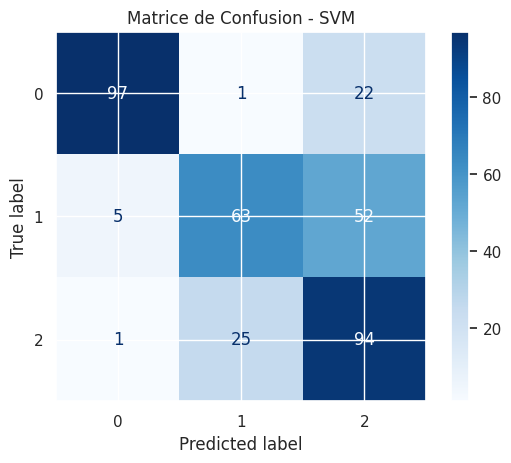



SVM - Rapport de Classification
              precision    recall  f1-score   support

           0       0.94      0.81      0.87       120
           1       0.71      0.53      0.60       120
           2       0.56      0.78      0.65       120

    accuracy                           0.71       360
   macro avg       0.74      0.71      0.71       360
weighted avg       0.74      0.71      0.71       360





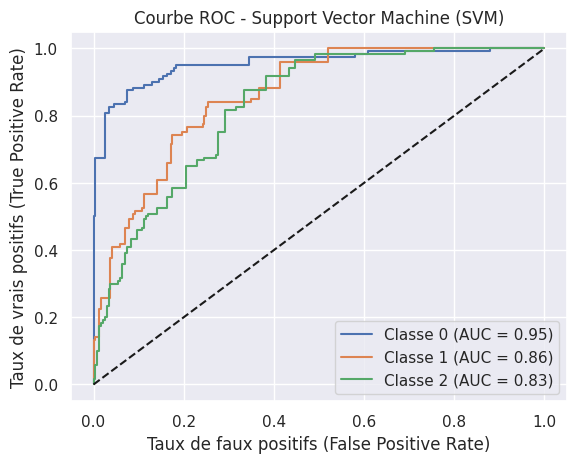

In [52]:
# Entraînement du modèle SVM
svm = SVC(kernel='linear', decision_function_shape='ovr', probability=True)
svm.fit(X_train, y_train)
# Prédictions et évaluation
y_pred_svm = svm.predict(X_test)
cm_svm = confusion_matrix(y_test, y_pred_svm)
ConfusionMatrixDisplay(cm_svm).plot(cmap="Blues")
plt.title("Matrice de Confusion - SVM")
plt.show()

print("\n" + "="*40 + "\n")

print("SVM - Rapport de Classification")
print(classification_report(y_test, y_pred_svm))

print("\n" + "="*40 + "\n")

# Courbe ROC et AUC
y_pred_proba_svm = svm.predict_proba(X_test)
fpr, tpr, roc_auc = {}, {}, {}
for i in range(y_test_bin.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba_svm[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f'Classe {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("Taux de faux positifs (False Positive Rate)")
plt.ylabel("Taux de vrais positifs (True Positive Rate)")
plt.title("Courbe ROC - Support Vector Machine (SVM)")
plt.legend()
plt.show()

## Modèle 3 : Decision Tree

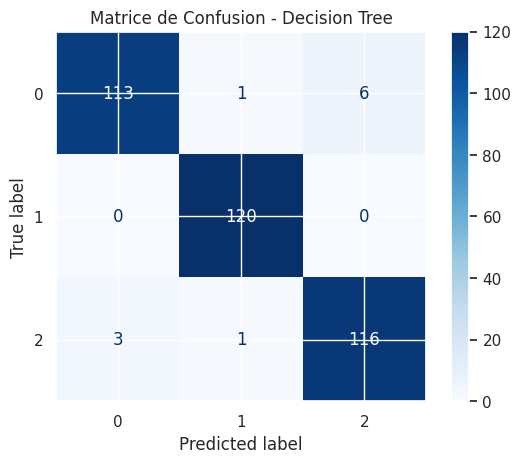



Decision Tree - Rapport de Classification
              precision    recall  f1-score   support

           0       0.97      0.94      0.96       120
           1       0.98      1.00      0.99       120
           2       0.95      0.97      0.96       120

    accuracy                           0.97       360
   macro avg       0.97      0.97      0.97       360
weighted avg       0.97      0.97      0.97       360





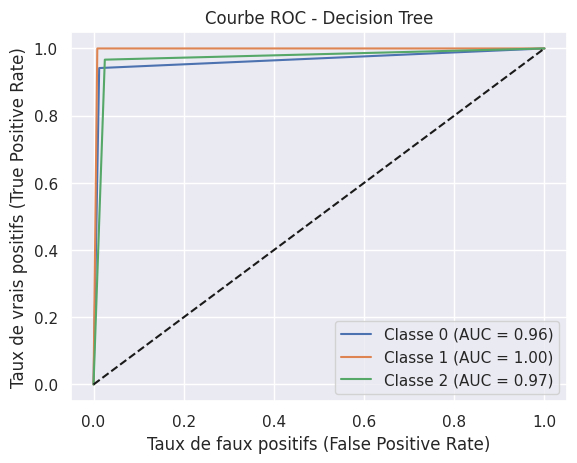

In [53]:
# Entraînement du modèle Decision Tree
decision_tree = DecisionTreeClassifier(random_state=42)
decision_tree.fit(X_train, y_train)
# Prédictions et évaluation
y_pred_tree = decision_tree.predict(X_test)
cm_tree = confusion_matrix(y_test, y_pred_tree)
ConfusionMatrixDisplay(cm_tree).plot(cmap="Blues")
plt.title("Matrice de Confusion - Decision Tree")
plt.show()

print("\n" + "="*40 + "\n")

print("Decision Tree - Rapport de Classification")
print(classification_report(y_test, y_pred_tree))

print("\n" + "="*40 + "\n")

# Courbe ROC et AUC
y_pred_proba_tree = decision_tree.predict_proba(X_test)
fpr, tpr, roc_auc = {}, {}, {}
for i in range(y_test_bin.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba_tree[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f'Classe {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("Taux de faux positifs (False Positive Rate)")
plt.ylabel("Taux de vrais positifs (True Positive Rate)")
plt.title("Courbe ROC - Decision Tree")
plt.legend()
plt.show()

## Modèle 4 : Random Forest

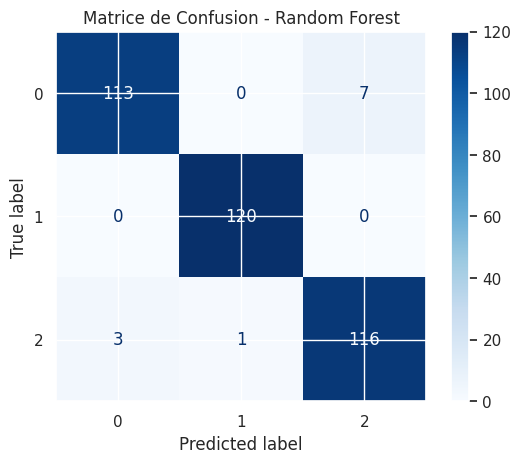



Random Forest - Rapport de Classification
              precision    recall  f1-score   support

           0       0.97      0.94      0.96       120
           1       0.99      1.00      1.00       120
           2       0.94      0.97      0.95       120

    accuracy                           0.97       360
   macro avg       0.97      0.97      0.97       360
weighted avg       0.97      0.97      0.97       360





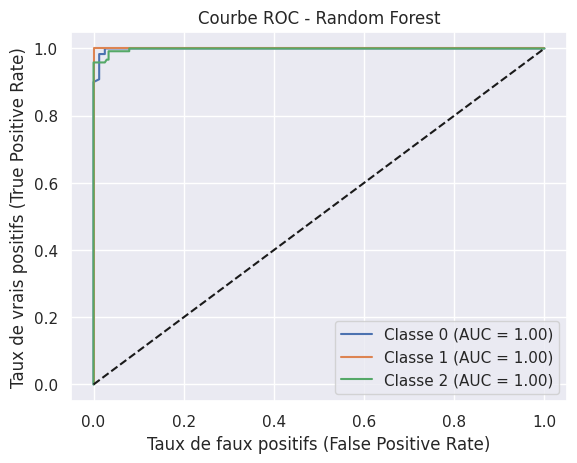

In [54]:
# Entraînement du modèle Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
# Prédictions et évaluation
y_pred_rf = rf.predict(X_test)
cm_rf = confusion_matrix(y_test, y_pred_rf)
ConfusionMatrixDisplay(cm_rf).plot(cmap="Blues")
plt.title("Matrice de Confusion - Random Forest")
plt.show()

print("\n" + "="*40 + "\n")

print("Random Forest - Rapport de Classification")
print(classification_report(y_test, y_pred_rf))

print("\n" + "="*40 + "\n")

# Courbe ROC et AUC
y_pred_proba_rf = rf.predict_proba(X_test)
fpr, tpr, roc_auc = {}, {}, {}
for i in range(y_test_bin.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba_rf[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f'Classe {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("Taux de faux positifs (False Positive Rate)")
plt.ylabel("Taux de vrais positifs (True Positive Rate)")
plt.title("Courbe ROC - Random Forest")
plt.legend()
plt.show()

## Modèle 5 : XGBoost

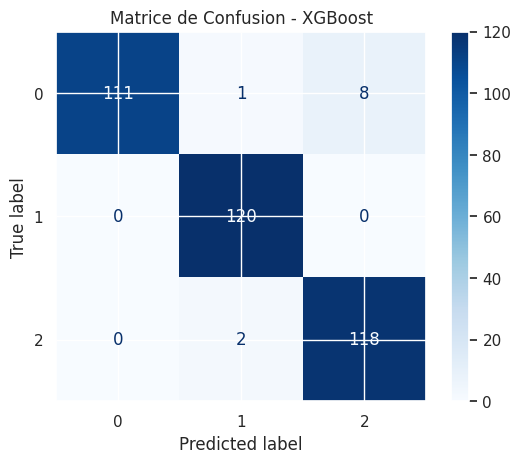



XGBoost - Rapport de Classification
              precision    recall  f1-score   support

           0       1.00      0.93      0.96       120
           1       0.98      1.00      0.99       120
           2       0.94      0.98      0.96       120

    accuracy                           0.97       360
   macro avg       0.97      0.97      0.97       360
weighted avg       0.97      0.97      0.97       360





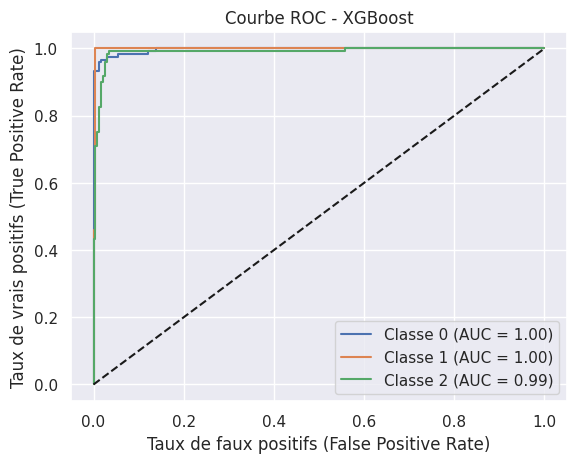

In [55]:
# Renommage des sets
y_train_xgb = y_train
y_test_xgb = y_test

# Création des DMatrix pour XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train_xgb)
dtest = xgb.DMatrix(X_test, label=y_test_xgb)

# Paramètres du modèle
params = {
    'objective': 'multi:softprob',
    'num_class': len(np.unique(y_train)),
    'eval_metric': 'mlogloss',
    'learning_rate': 0.1,
    'max_depth': 6,
    'seed': 42
}

# Liste des jeux de données pour l'évaluation
evals = [(dtrain, 'train'), (dtest, 'eval')]

# Entraînement du modèle avec suivi de l'évolution
num_round = 100  # Nombre d'itérations (époques)
evals_result = {}
bst = xgb.train(params, dtrain, num_round, evals=evals, evals_result=evals_result, verbose_eval=False)

# Prédictions
y_pred_proba = bst.predict(dtest)  # Prédictions probabilistes
y_pred = np.argmax(y_pred_proba, axis=1)  # Prédictions des classes

# Évaluation
cm_xgb = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm_xgb).plot(cmap="Blues")
plt.title("Matrice de Confusion - XGBoost")
plt.show()

print("\n" + "="*40 + "\n")

print("XGBoost - Rapport de Classification")
print(classification_report(y_test, y_pred))

print("\n" + "="*40 + "\n")

# Courbe ROC et AUC
from sklearn.preprocessing import label_binarize

classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)

fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f'Classe {classes[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("Taux de faux positifs (False Positive Rate)")
plt.ylabel("Taux de vrais positifs (True Positive Rate)")
plt.title("Courbe ROC - XGBoost")
plt.legend()
plt.show()



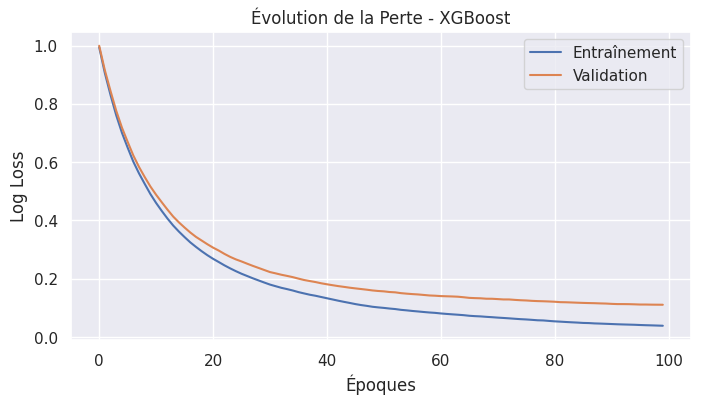

In [56]:
# Récupération des résultats
epochs = len(evals_result['train']['mlogloss'])
x_axis = range(0, epochs)
# Tracé de la courbe de perte
plt.figure(figsize=(8, 4))
plt.plot(x_axis, evals_result['train']['mlogloss'], label='Entraînement')
plt.plot(x_axis, evals_result['eval']['mlogloss'], label='Validation')
plt.title('Évolution de la Perte - XGBoost')
plt.xlabel('Époques')
plt.ylabel('Log Loss')
plt.legend()
plt.show()

## Modèle 6 : Logistic Regression

/home/gaubu/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


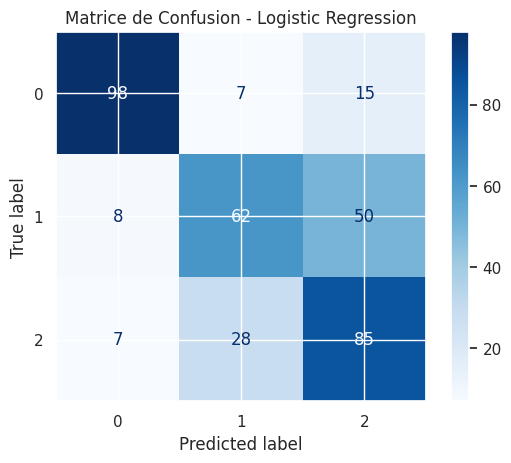



Logistic Regression - Rapport de Classification
              precision    recall  f1-score   support

           0       0.87      0.82      0.84       120
           1       0.64      0.52      0.57       120
           2       0.57      0.71      0.63       120

    accuracy                           0.68       360
   macro avg       0.69      0.68      0.68       360
weighted avg       0.69      0.68      0.68       360





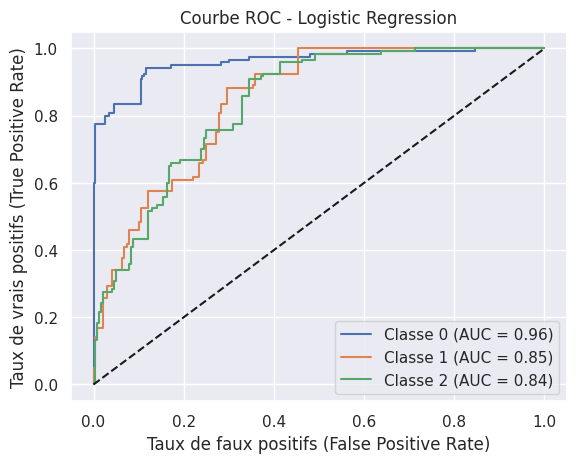

In [57]:
# Entraînement du modèle Logistic Regression
logreg = LogisticRegression(multi_class='multinomial', max_iter=1000, random_state=42)
logreg.fit(X_train, y_train)
# Prédictions et évaluation
y_pred_logreg = logreg.predict(X_test)
cm_logreg = confusion_matrix(y_test, y_pred_logreg)
ConfusionMatrixDisplay(cm_logreg).plot(cmap="Blues")
plt.title("Matrice de Confusion - Logistic Regression")
plt.show()

print("\n" + "="*40 + "\n")

print("Logistic Regression - Rapport de Classification")
print(classification_report(y_test, y_pred_logreg))

print("\n" + "="*40 + "\n")

# Courbe ROC et AUC
y_pred_proba_logreg = logreg.predict_proba(X_test)
fpr, tpr, roc_auc = {}, {}, {}
for i in range(y_test_bin.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba_logreg[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f'Classe {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("Taux de faux positifs (False Positive Rate)")
plt.ylabel("Taux de vrais positifs (True Positive Rate)")
plt.title("Courbe ROC - Logistic Regression")
plt.legend()
plt.show()

## Modèle 7 : Naive Bayes

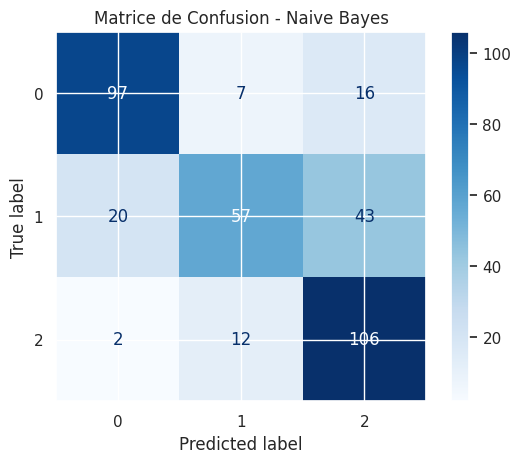



Naive Bayes - Rapport de Classification
              precision    recall  f1-score   support

           0       0.82      0.81      0.81       120
           1       0.75      0.47      0.58       120
           2       0.64      0.88      0.74       120

    accuracy                           0.72       360
   macro avg       0.74      0.72      0.71       360
weighted avg       0.74      0.72      0.71       360





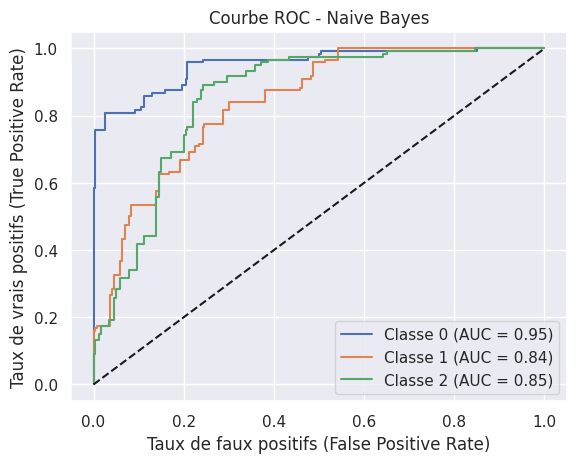

In [58]:
# Entraînement du modèle Naive Bayes
naive_bayes = GaussianNB()
naive_bayes.fit(X_train, y_train)
# Prédictions et évaluation
y_pred_nb = naive_bayes.predict(X_test)
cm_nb = confusion_matrix(y_test, y_pred_nb)
ConfusionMatrixDisplay(cm_nb).plot(cmap="Blues")
plt.title("Matrice de Confusion - Naive Bayes")
plt.show()

print("\n" + "="*40 + "\n")

print("Naive Bayes - Rapport de Classification")
print(classification_report(y_test, y_pred_nb))

print("\n" + "="*40 + "\n")

# Courbe ROC et AUC
y_pred_proba_nb = naive_bayes.predict_proba(X_test)
fpr, tpr, roc_auc = {}, {}, {}
for i in range(y_test_bin.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba_nb[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f'Classe {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("Taux de faux positifs (False Positive Rate)")
plt.ylabel("Taux de vrais positifs (True Positive Rate)")
plt.title("Courbe ROC - Naive Bayes")
plt.legend()
plt.show()

# Modèle 8 : Artificial Neural Network (ANN)

## Définition et entraînement de l'ANN

In [59]:
# Définition du modèle ANN de base
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(16, activation='relu'))
model.add(Dense(len(np.unique(y_train)), activation='softmax'))  # Nombre de neurones de sortie = nombre de classes
# Compilation du modèle
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

/home/gaubu/.local/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [60]:
# Entraînement du modèle
history_ann = model.fit(X_train, y_train, epochs=140, validation_data=(X_test, y_test), verbose=1)

Epoch 1/140
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.4422 - loss: 1.1001 - val_accuracy: 0.6722 - val_loss: 0.7789
Epoch 2/140
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6557 - loss: 0.7827 - val_accuracy: 0.7361 - val_loss: 0.6296
Epoch 3/140
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6898 - loss: 0.6729 - val_accuracy: 0.7556 - val_loss: 0.5879
Epoch 4/140
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7079 - loss: 0.6346 - val_accuracy: 0.7417 - val_loss: 0.5459
Epoch 5/140
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7298 - loss: 0.6181 - val_accuracy: 0.7306 - val_loss: 0.5235
Epoch 6/140
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7338 - loss: 0.5899 - val_accuracy: 0.7528 - val_loss: 0.5115
Epoch 7/140
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7691 - loss: 0.5465 - val_accuracy: 0.7167 - val_loss: 0.5060
Epoch 8/140
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7506 - loss: 0.5574 - val_accuracy: 0.7361 - 

## Évaluation du modèle

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


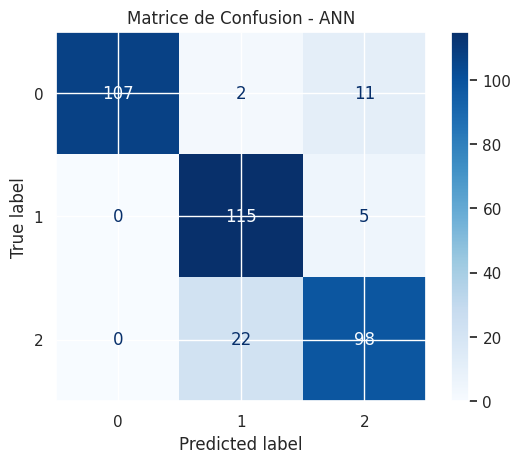

ANN - Rapport de Classification
              precision    recall  f1-score   support

           0       1.00      0.89      0.94       120
           1       0.83      0.96      0.89       120
           2       0.86      0.82      0.84       120

    accuracy                           0.89       360
   macro avg       0.90      0.89      0.89       360
weighted avg       0.90      0.89      0.89       360



In [61]:
# Prédictions sur le jeu de test
y_pred_ann = model.predict(X_test)
y_pred_labels_ann = np.argmax(y_pred_ann, axis=1)
# Matrice de confusion
cm_ann = confusion_matrix(y_test, y_pred_labels_ann)
ConfusionMatrixDisplay(cm_ann).plot(cmap="Blues")
plt.title("Matrice de Confusion - ANN")
plt.show()
# Rapport de classification
print("ANN - Rapport de Classification")
print(classification_report(y_test, y_pred_labels_ann))

## Affichage des Courbes d'Entraînement (Accuracy et Loss)

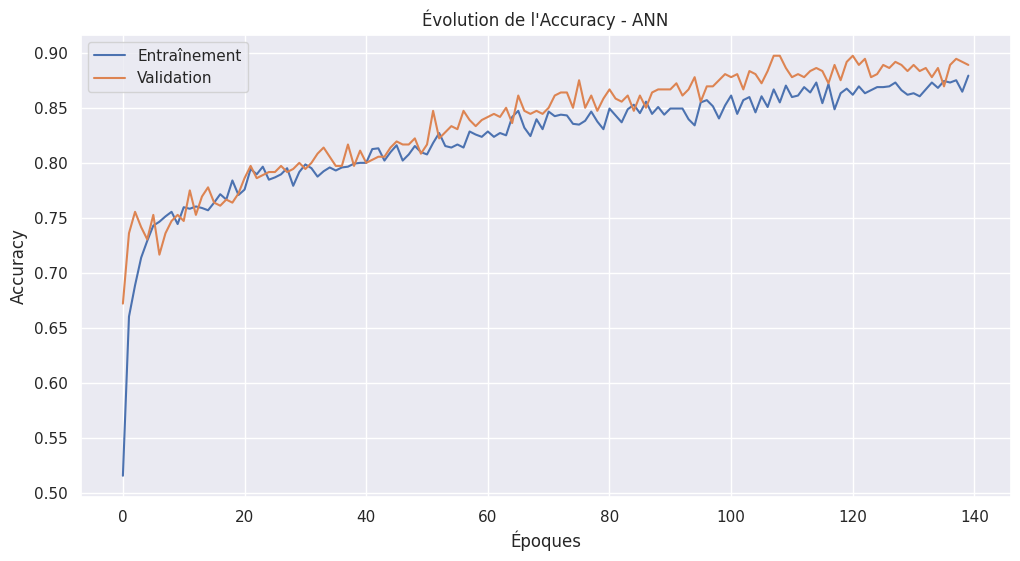

In [62]:
# Évolution de l'Accuracy
plt.figure(figsize=(12, 6))
plt.plot(history_ann.history['accuracy'], label='Entraînement')
plt.plot(history_ann.history['val_accuracy'], label='Validation')
plt.title("Évolution de l'Accuracy - ANN")
plt.xlabel("Époques")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

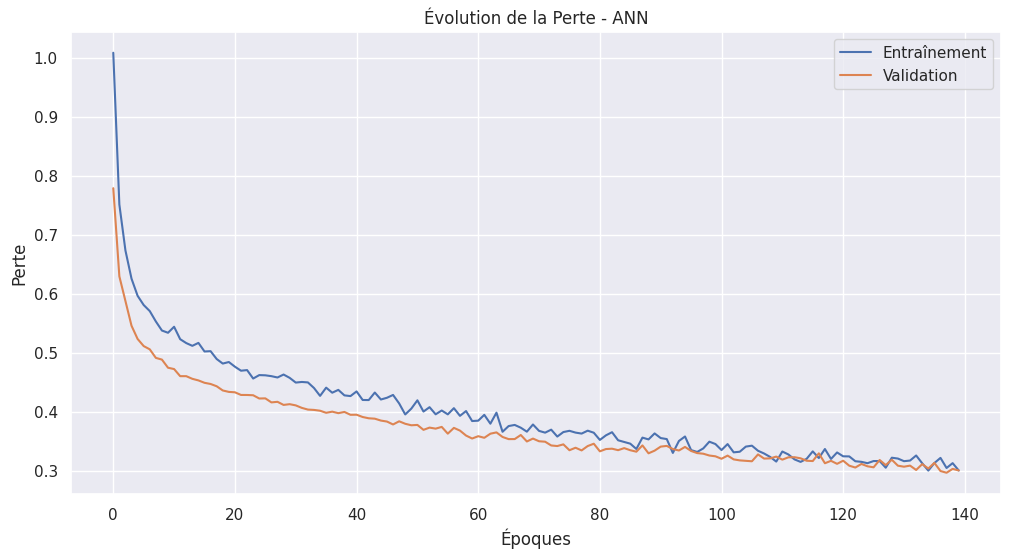

In [63]:
# Évolution de la Perte
plt.figure(figsize=(12, 6))
plt.plot(history_ann.history['loss'], label='Entraînement')
plt.plot(history_ann.history['val_loss'], label='Validation')
plt.title("Évolution de la Perte - ANN")
plt.xlabel("Époques")
plt.ylabel("Perte")
plt.legend()
plt.show()

# Optimisation du Modèle ANN avec Keras Tuner

In [67]:
# Fonction pour créer le modèle
def build_model(hp):
    model = Sequential()
    for i in range(hp.Int('num_layers', 2, 5)):
        units = hp.Int(f'units_{i}', min_value=64, max_value=256, step=64)
        activation_choice = hp.Choice('activation', ['relu', 'leaky_relu', 'elu'])
        if activation_choice == 'leaky_relu':
            model.add(Dense(units))
            model.add(LeakyReLU())
        elif activation_choice == 'elu':
            model.add(Dense(units))
            model.add(ELU())
        else:
            model.add(Dense(units, activation='relu'))
        dropout_rate = hp.Float(f'dropout_{i}', 0.2, 0.5, step=0.1)
        model.add(Dropout(rate=dropout_rate))
    model.add(Dense(len(np.unique(y_train)), activation='softmax'))
    learning_rate = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model
# Configuration du tuner
tuner = kt.Hyperband(build_model, objective='val_accuracy', max_epochs=50,
                     factor=3, directory='my_dir',
                     project_name='ANN_hyperparameter_tuning')
# Recherche des meilleurs hyperparamètres
tuner.search(X_train, y_train, epochs=50, validation_data=(X_test, y_test), verbose=1)

Trial 90 Complete [00h 00m 25s]
val_accuracy: 0.8500000238418579

Best val_accuracy So Far: 0.8916666507720947
Total elapsed time: 00h 14m 15s


## Affichage des meilleurs hyperparamètres

In [70]:
# Récupération des meilleurs hyperparamètres
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Meilleurs hyperparamètres trouvés :")
print(f"Nombre optimal de couches cachées : {best_hps.get('num_layers')}")
for i in range(best_hps.get('num_layers')):
    units = best_hps.get(f'units_{i}')
    activation = best_hps.get('activation')
    dropout = best_hps.get(f'dropout_{i}')
    print(f"Couche {i+1} - Neurones : {units}, Activation : {activation}, Dropout : {dropout}")
print(f"Taux d'apprentissage optimal : {best_hps.get('learning_rate')}")

Meilleurs hyperparamètres trouvés :
Nombre optimal de couches cachées : 4
Couche 1 - Neurones : 192, Activation : leaky_relu, Dropout : 0.4
Couche 2 - Neurones : 256, Activation : leaky_relu, Dropout : 0.2
Couche 3 - Neurones : 128, Activation : leaky_relu, Dropout : 0.30000000000000004
Couche 4 - Neurones : 128, Activation : leaky_relu, Dropout : 0.2
Taux d'apprentissage optimal : 0.001


## Entrainement du meilleur modèle et visualisation

In [71]:
  # Construction du modèle avec les meilleurs hyperparamètres
best_model = tuner.hypermodel.build(best_hps)
# Entraînement du modèle
history = best_model.fit(X_train, y_train, epochs=120, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/120
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.6220 - loss: 0.7943 - val_accuracy: 0.7472 - val_loss: 0.5396
Epoch 2/120
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7440 - loss: 0.5865 - val_accuracy: 0.7500 - val_loss: 0.5101
Epoch 3/120
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7443 - loss: 0.5545 - val_accuracy: 0.7778 - val_loss: 0.4902
Epoch 4/120
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7631 - loss: 0.5386 - val_accuracy: 0.7694 - val_loss: 0.4673
Epoch 5/120
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7603 - loss: 0.5021 - val_accuracy: 0.7861 - val_loss: 0.4697
Epoch 6/120
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7940 - loss: 0.4527 - val_accuracy: 0.7667 - val_loss: 0.4556
Epoch 7/120
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7545 - loss: 0.5048 - val_accuracy: 0.7722 - val_loss: 0.4565
Epoch 8/120
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7583 - loss: 0.4919 - val_accuracy: 0.7778 -

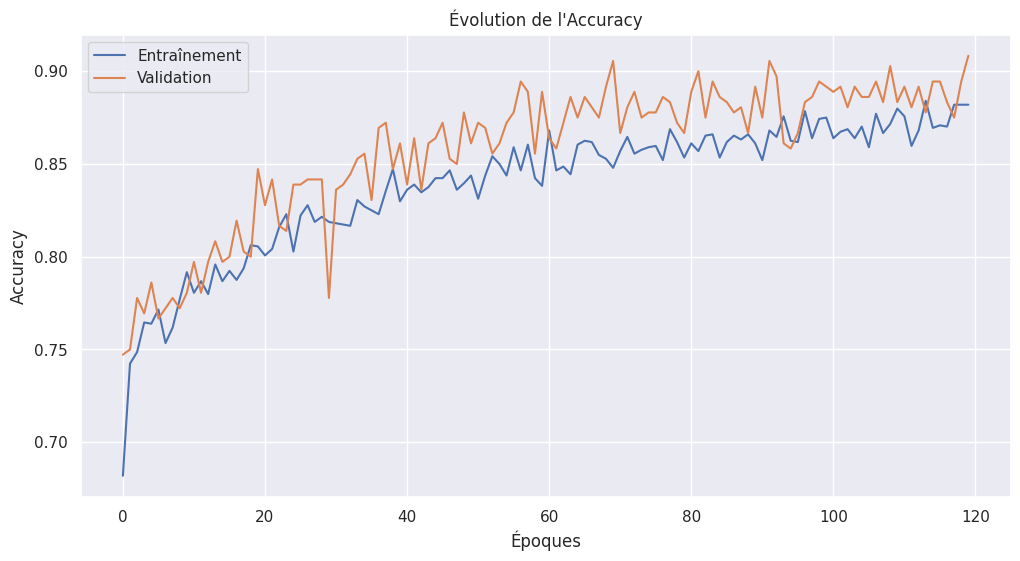

In [72]:
# Évolution de l'Accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Entraînement')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title("Évolution de l'Accuracy")
plt.xlabel("Époques")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

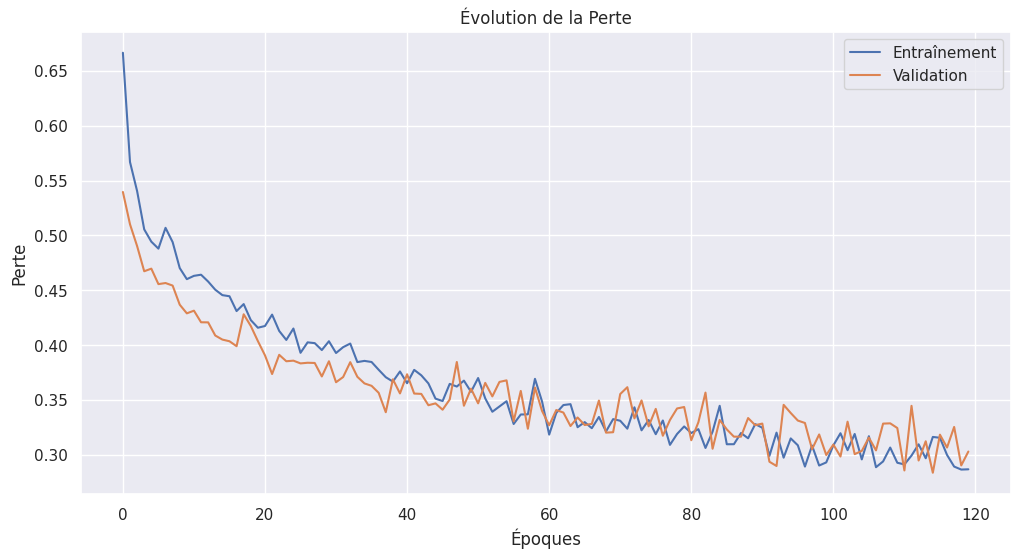

In [73]:
# Évolution de la Perte
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Entraînement')
plt.plot(history.history['val_loss'], label='Validation')
plt.title("Évolution de la Perte")
plt.xlabel("Époques")
plt.ylabel("Perte")
plt.legend()
plt.show()

## Évaluation du modèle optimisé

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


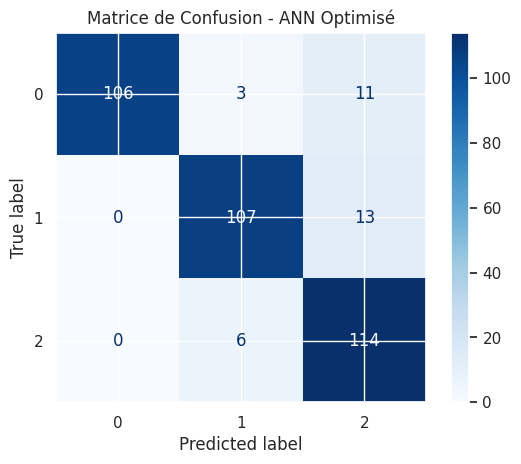

ANN Optimisé - Rapport de Classification
              precision    recall  f1-score   support

           0       1.00      0.88      0.94       120
           1       0.92      0.89      0.91       120
           2       0.83      0.95      0.88       120

    accuracy                           0.91       360
   macro avg       0.92      0.91      0.91       360
weighted avg       0.92      0.91      0.91       360



In [74]:
# Prédictions sur le jeu de test
y_pred_ann = best_model.predict(X_test)
y_pred_labels_ann = np.argmax(y_pred_ann, axis=1)
# Matrice de confusion
cm_ann = confusion_matrix(y_test, y_pred_labels_ann)
ConfusionMatrixDisplay(cm_ann).plot(cmap="Blues")
plt.title("Matrice de Confusion - ANN Optimisé")
plt.show()
print("ANN Optimisé - Rapport de Classification")
print(classification_report(y_test, y_pred_labels_ann))

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


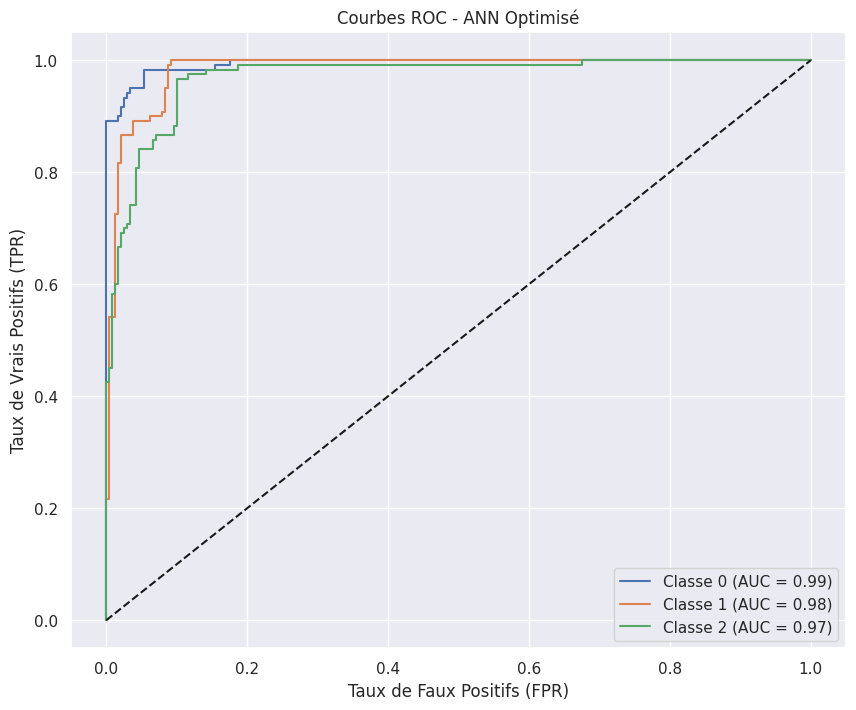

In [75]:
# Binarisation des labels pour le calcul de la courbe ROC
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_bin.shape[1]

# Prédictions des probabilités par le modèle ANN optimisé
y_pred_proba = best_model.predict(X_test)

# Calcul des courbes ROC et des AUC pour chaque classe
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Tracé des courbes ROC pour chaque classe
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Classe {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonale
plt.xlabel("Taux de Faux Positifs (FPR)")
plt.ylabel("Taux de Vrais Positifs (TPR)")
plt.title("Courbes ROC - ANN Optimisé")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## Tableau récapitulatif de tout les modèles

In [76]:
# Calcul des métriques pour chaque modèle
metrics = {
    'Modèle': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1-Score': []
}

# Liste des modèles et leurs prédictions
models = {
    'K-Nearest Neighbors (KNN)': knn.predict(X_test),
    'Support Vector Machine (SVM)': svm.predict(X_test),
    'Decision Tree': decision_tree.predict(X_test),
    'Random Forest': rf.predict(X_test),
    'XGBoost': y_pred,  # Prédictions calculées précédemment
    'Logistic Regression': logreg.predict(X_test),
    'Naive Bayes': naive_bayes.predict(X_test),
    'Artificial Neural Network (ANN)': np.argmax(model.predict(X_test), axis=1),
    'Optimized ANN (Keras Tuner)': np.argmax(best_model.predict(X_test), axis=1)
}

for model_name, y_pred in models.items():
    metrics['Modèle'].append(model_name)
    metrics['Accuracy'].append(accuracy_score(y_test, y_pred))
    metrics['Precision'].append(precision_score(y_test, y_pred, average='weighted', zero_division=0))
    metrics['Recall'].append(recall_score(y_test, y_pred, average='weighted'))
    metrics['F1-Score'].append(f1_score(y_test, y_pred, average='weighted'))

# Création d'un DataFrame
summary_table = pd.DataFrame(metrics).set_index('Modèle')

# Transposition du DataFrame pour inverser les axes
summary_table = summary_table.T

# Mise en forme pour afficher en gras le meilleur modèle pour chaque indicateur
def highlight_max(row):
    return ['font-weight: bold' if v == row.max() else '' for v in row]

styled_table = summary_table.style.apply(highlight_max, axis=1)

# Affichage du tableau récapitulatif
styled_table



12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Modèle,K-Nearest Neighbors (KNN),Support Vector Machine (SVM),Decision Tree,Random Forest,XGBoost,Logistic Regression,Naive Bayes,Artificial Neural Network (ANN),Optimized ANN (Keras Tuner)
Accuracy,0.938889,0.705556,0.969444,0.969444,0.969444,0.680556,0.722222,0.888889,0.908333
Precision,0.941433,0.736379,0.969521,0.969654,0.970706,0.691033,0.735850,0.895662,0.916167
Recall,0.938889,0.705556,0.969444,0.969444,0.969444,0.680556,0.722222,0.888889,0.908333
F1-Score,0.938577,0.708535,0.969347,0.969403,0.969348,0.680753,0.712403,0.889456,0.909518


# Enregistrement des poids du modèle XGBoost (meilleur) ainsi que PCA et Scaler

In [83]:
# Exemple pour sauvegarder un StandardScaler
joblib.dump(scaler, 'classifier/weights/scaler.pkl')

# Entraînez du PCA
pca = PCA(n_components=0.95)  # Exemple de PCA, ajusté sur 95% de la variance
X_train_pca = pca.fit_transform(X_scaled)
# Enregistrez l'instance de PCA
joblib.dump(pca, 'classifier/weights/pca.pkl')

# Création du dossier principal 'weights' s'il n'existe pas
if not os.path.exists('weights'):
    os.makedirs('weights')

bst.save_model("classifier/weights/xgboost_classifier.json")